# Setup

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
!pip install kneed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Anomaly Detection/household_power_consumption.txt', sep=";")


<ipython-input-3-755e9dd2df8c>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/gdrive/MyDrive/Anomaly Detection/household_power_consumption.txt', sep=";")


1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt). Global active power is the power consumed by appliances other than the appliances mapped to Sub Meters. Global active power is the real power consumption i.e. the power consumed by electrical appliances other than the sub metered appliances.It is basically called wattfull power.

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt). Global reactive power is the power which bounces back and froth without any usage or leakage. It is the imaginary power consumption. It is basically called wattless power.

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere). Intensity is magnitude of the power consumed. Also called as strength of current.

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [ ]:
data

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


drop incomplete day

In [ ]:
data = data.drop(range(2073996,2075259))

In [ ]:
data = data.drop(range(0,396))


# Preprocessing


In [ ]:
data["period"] = data["Date"] + " " + data["Time"]


In [ ]:
data = data.set_index('period')


In [ ]:
data.loc["17/12/2006 00:00:00"]

Date                     17/12/2006
Time                       00:00:00
Global_active_power           1.044
Global_reactive_power         0.152
Voltage                     242.730
Global_intensity              4.400
Sub_metering_1                0.000
Sub_metering_2                2.000
Sub_metering_3                  0.0
Name: 17/12/2006 00:00:00, dtype: object

In [ ]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
period,,,,,,,
17/12/2006 00:00:00,1.044,0.152,242.730,4.400,0.000,2.000,0.0
17/12/2006 00:01:00,1.520,0.220,242.200,7.400,0.000,1.000,0.0
17/12/2006 00:02:00,3.038,0.194,240.140,12.600,0.000,2.000,0.0
17/12/2006 00:03:00,2.974,0.194,239.970,12.400,0.000,1.000,0.0
17/12/2006 00:04:00,2.846,0.198,240.390,11.800,0.000,2.000,0.0
...,...,...,...,...,...,...,...
25/11/2010 23:55:00,0.58,0.202,245.66,2.6,0.0,1.0,0.0
25/11/2010 23:56:00,0.484,0.202,245.55,2.2,0.0,1.0,0.0
25/11/2010 23:57:00,0.408,0.206,245.73,1.8,0.0,2.0,0.0


In [ ]:
data = data.drop('Date', axis=1)
data = data.drop('Time', axis = 1)

In [ ]:
data_no_na = data[~data['Voltage'].str.contains('?',regex=False,na=False)]


In [ ]:
data_no_na

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
period,,,,,,,
17/12/2006 00:00:00,1.044,0.152,242.730,4.400,0.000,2.000,0.0
17/12/2006 00:01:00,1.520,0.220,242.200,7.400,0.000,1.000,0.0
17/12/2006 00:02:00,3.038,0.194,240.140,12.600,0.000,2.000,0.0
17/12/2006 00:03:00,2.974,0.194,239.970,12.400,0.000,1.000,0.0
17/12/2006 00:04:00,2.846,0.198,240.390,11.800,0.000,2.000,0.0
...,...,...,...,...,...,...,...
25/11/2010 23:55:00,0.58,0.202,245.66,2.6,0.0,1.0,0.0
25/11/2010 23:56:00,0.484,0.202,245.55,2.2,0.0,1.0,0.0
25/11/2010 23:57:00,0.408,0.206,245.73,1.8,0.0,2.0,0.0


In [ ]:
data.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [ ]:
data_no_na.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
data_no_na['Global_active_power'] = (data_no_na['Global_active_power']).astype(float)
data_no_na['Voltage'] = (data_no_na['Voltage']).astype(float)
data_no_na['Global_reactive_power'] = (data_no_na['Global_reactive_power']).astype(float)
data_no_na['Global_intensity'] = (data_no_na['Global_intensity']).astype(float)
data_no_na['Sub_metering_1'] = (data_no_na['Sub_metering_1']).astype(float)
data_no_na['Sub_metering_2'] = (data_no_na['Sub_metering_2']).astype(float)
data_no_na['Sub_metering_3'] = (data_no_na['Sub_metering_3']).astype(float)

<ipython-input-56-7e0725d57c0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['Global_active_power'] = (data_no_na['Global_active_power']).astype(float)
<ipython-input-56-7e0725d57c0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['Voltage'] = (data_no_na['Voltage']).astype(float)
<ipython-input-56-7e0725d57c0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [ ]:
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'], errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'], errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'], errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'], errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'], errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'], errors='coerce')


In [ ]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
period,,,,,,,
17/12/2006 00:00:00,1.044,0.152,242.73,4.4,0.0,2.0,0.0
17/12/2006 00:01:00,1.520,0.220,242.20,7.4,0.0,1.0,0.0
17/12/2006 00:02:00,3.038,0.194,240.14,12.6,0.0,2.0,0.0
17/12/2006 00:03:00,2.974,0.194,239.97,12.4,0.0,1.0,0.0
17/12/2006 00:04:00,2.846,0.198,240.39,11.8,0.0,2.0,0.0
...,...,...,...,...,...,...,...
25/11/2010 23:55:00,0.580,0.202,245.66,2.6,0.0,1.0,0.0
25/11/2010 23:56:00,0.484,0.202,245.55,2.2,0.0,1.0,0.0
25/11/2010 23:57:00,0.408,0.206,245.73,1.8,0.0,2.0,0.0


In [ ]:
# initialize lists to store the column sums and averages
sums_A = []
sums_B = []
averages_C = []
sums_D = []
sums_E = []
sums_F = []
sums_G = []
# loop through every 60 rows and calculate the column sums and averages
for i in range(0, len(data), 60):
    df_slice = data.iloc[i:i+60, :]
    sum_A = df_slice['Global_active_power'].sum()
    sum_B = df_slice['Global_reactive_power'].sum()
    avg_C = df_slice['Voltage'].mean()
    sum_D = df_slice['Global_intensity'].sum()
    sum_E = df_slice['Sub_metering_1'].sum()
    sum_F = df_slice['Sub_metering_2'].sum()
    sum_G = df_slice['Sub_metering_3'].sum()

    sums_A.append(sum_A)
    sums_B.append(sum_B)
    averages_C.append(avg_C)
    sums_D.append(sum_D)
    sums_E.append(sum_E)
    sums_F.append(sum_F)
    sums_G.append(sum_G)


# create a new dataframe with the column sums and averages
df_per_hour = pd.DataFrame({'Global_active_power': sums_A, 'Global_reactive_power': sums_B, 'Voltage': averages_C, 'Global_intensity': sums_D, 'Sub_metering_1': sums_E, 'Sub_metering_2': sums_F, 'Sub_metering_3': sums_G})

In [ ]:
df_per_hour

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,112.948,6.146,240.961833,487.6,0.0,28.0,0.0
1,200.964,8.216,240.448333,854.8,0.0,1514.0,0.0
2,95.236,4.694,245.818667,412.2,0.0,34.0,0.0
3,99.732,4.772,244.513500,432.4,0.0,46.0,0.0
4,132.946,5.608,243.855500,560.0,0.0,34.0,533.0
...,...,...,...,...,...,...,...
34555,139.828,9.094,237.729667,588.0,0.0,40.0,502.0
34556,98.870,5.882,241.659000,409.6,0.0,33.0,0.0
34557,80.576,2.966,240.698833,332.4,0.0,0.0,0.0
34558,74.854,4.736,241.979500,309.6,0.0,0.0,318.0


In [ ]:
# define a formula to apply to each row
def formula(row):
    return (row['Global_active_power']*1000/60) - row['Sub_metering_1'] - row['Sub_metering_2'] - row['Sub_metering_3']

# apply the formula to each row and create a new column called "4"
df_per_hour['Sub_metering_4'] = df_per_hour.apply(formula, axis=1)

In [ ]:
df_per_hour

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
0,112.948,6.146,240.961833,487.6,0.0,28.0,0.0,1854.466667
1,200.964,8.216,240.448333,854.8,0.0,1514.0,0.0,1835.400000
2,95.236,4.694,245.818667,412.2,0.0,34.0,0.0,1553.266667
3,99.732,4.772,244.513500,432.4,0.0,46.0,0.0,1616.200000
4,132.946,5.608,243.855500,560.0,0.0,34.0,533.0,1648.766667
...,...,...,...,...,...,...,...,...
34555,139.828,9.094,237.729667,588.0,0.0,40.0,502.0,1788.466667
34556,98.870,5.882,241.659000,409.6,0.0,33.0,0.0,1614.833333
34557,80.576,2.966,240.698833,332.4,0.0,0.0,0.0,1342.933333
34558,74.854,4.736,241.979500,309.6,0.0,0.0,318.0,929.566667


In [ ]:
start_date = datetime.datetime(2006, 12, 17, 0, 0, 0)
end_date = datetime.datetime(2010, 11, 25, 23, 0, 0)
delta = datetime.timedelta(hours=1)

hourly_dates = []
while start_date <= end_date:
    hourly_dates.append(start_date)
    start_date += delta

In [ ]:
df_per_hour['label'] = hourly_dates

In [ ]:
df_per_hour = df_per_hour.set_index('label')


In [ ]:
df_per_hour

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
label,,,,,,,,
2006-12-17 00:00:00,112.948,6.146,240.961833,487.6,0.0,28.0,0.0,1854.466667
2006-12-17 01:00:00,200.964,8.216,240.448333,854.8,0.0,1514.0,0.0,1835.400000
2006-12-17 02:00:00,95.236,4.694,245.818667,412.2,0.0,34.0,0.0,1553.266667
2006-12-17 03:00:00,99.732,4.772,244.513500,432.4,0.0,46.0,0.0,1616.200000
2006-12-17 04:00:00,132.946,5.608,243.855500,560.0,0.0,34.0,533.0,1648.766667
...,...,...,...,...,...,...,...,...
2010-11-25 19:00:00,139.828,9.094,237.729667,588.0,0.0,40.0,502.0,1788.466667
2010-11-25 20:00:00,98.870,5.882,241.659000,409.6,0.0,33.0,0.0,1614.833333
2010-11-25 21:00:00,80.576,2.966,240.698833,332.4,0.0,0.0,0.0,1342.933333


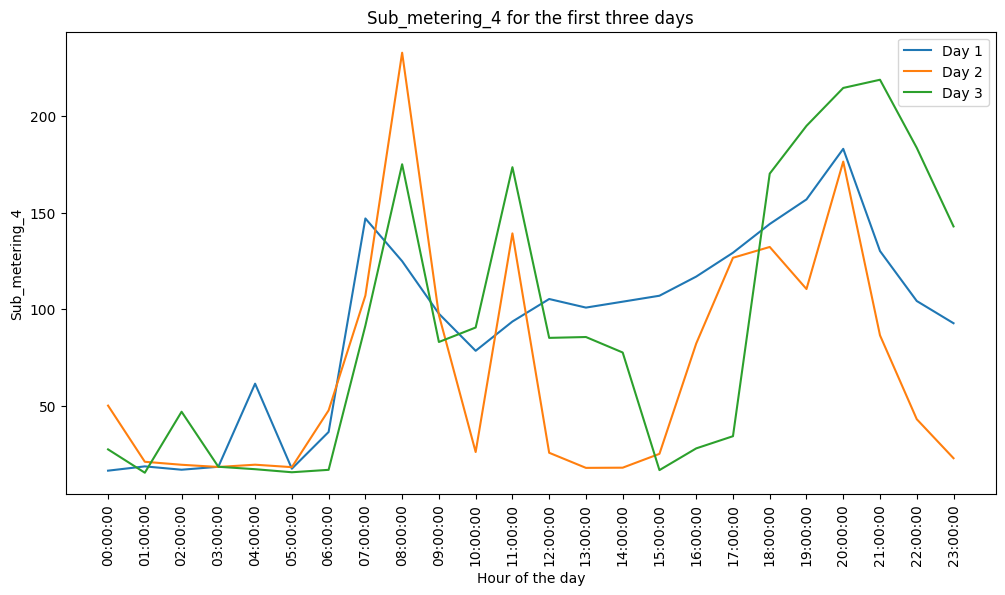

In [ ]:
import matplotlib.pyplot as plt

# filter dataframe for the first three days
df_first_three_days = df_per_hour.loc['2006-12-18 00:00:00':'2006-12-20 23:00:00']
# create a list of hours as strings from 00:00:00 to 23:00:00
hours = [f'{i:02d}:00:00' for i in range(24)]

# plot the data for each day with a different color
fig, ax = plt.subplots(figsize=(12,6))
for day in range(3):
    start = day*24
    end = start+24
    ax.plot(hours, df_first_three_days['Global_active_power'][start:end], label=f'Day {day+1}')

# set plot attributes
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sub_metering_4')
ax.set_title('Sub_metering_4 for the first three days')
ax.legend()
plt.xticks(rotation='vertical')

plt.show()

In [ ]:
# assuming your dataframe is called "df"
voltage_less_than_20 = df_per_hour[df_per_hour["Global_active_power"] < 20]

In [ ]:
voltage_less_than_20

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
label,,,,,,,,
2006-12-18 00:00:00,16.582,5.944,244.607500,73.4,0.0,2.0,0.0,274.366667
2006-12-18 01:00:00,18.798,9.114,243.519333,85.0,0.0,35.0,0.0,278.300000
2006-12-18 02:00:00,17.068,6.544,246.891000,75.4,0.0,0.0,0.0,284.466667
2006-12-18 03:00:00,18.596,8.866,245.731833,84.0,0.0,34.0,0.0,275.933333
2006-12-18 05:00:00,17.610,7.316,245.253167,77.6,0.0,28.0,0.0,265.500000
...,...,...,...,...,...,...,...,...
2010-11-25 00:00:00,18.208,4.406,241.053333,78.4,0.0,13.0,0.0,290.466667
2010-11-25 01:00:00,17.380,3.686,242.102500,75.0,0.0,0.0,0.0,289.666667
2010-11-25 02:00:00,15.982,3.710,242.468833,70.2,0.0,0.0,0.0,266.366667


# Test

Tomamos las primeras 24 hrs disponibles

In [ ]:
x = df_per_hour[0:1380]
x

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
0,112.948,6.146,240.961833,487.6,0.0,28.0,0.0,1854.466667
1,200.964,8.216,240.448333,854.8,0.0,1514.0,0.0,1835.400000
2,95.236,4.694,245.818667,412.2,0.0,34.0,0.0,1553.266667
3,99.732,4.772,244.513500,432.4,0.0,46.0,0.0,1616.200000
4,132.946,5.608,243.855500,560.0,0.0,34.0,533.0,1648.766667
...,...,...,...,...,...,...,...,...
1375,150.550,4.748,239.509833,625.6,16.0,0.0,1055.0,1438.166667
1376,124.126,7.340,239.527833,516.6,536.0,32.0,1055.0,445.766667
1377,117.848,4.712,237.983667,494.0,606.0,16.0,1042.0,300.133333
1378,80.798,3.502,236.842000,339.2,0.0,0.0,1032.0,314.633333


In [ ]:
y = data_no_na[1776:1836]
y

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
period,,,,,,,
17/12/2006 23:00:00,1.116,0.344,245.22,4.8,0.0,0.0,0.0
17/12/2006 23:01:00,0.864,0.308,245.40,3.8,0.0,0.0,0.0
17/12/2006 23:02:00,0.724,0.276,245.89,3.0,0.0,0.0,0.0
17/12/2006 23:03:00,0.602,0.276,245.37,2.6,0.0,0.0,0.0
17/12/2006 23:04:00,0.566,0.278,245.56,2.6,0.0,0.0,0.0
17/12/2006 23:05:00,0.566,0.280,245.82,2.6,0.0,0.0,0.0
17/12/2006 23:06:00,0.566,0.284,246.65,2.6,0.0,0.0,0.0
17/12/2006 23:07:00,0.564,0.278,245.90,2.4,0.0,0.0,0.0
17/12/2006 23:08:00,0.560,0.274,245.04,2.4,0.0,0.0,0.0


In [ ]:
df_sums = pd.concat(sums, axis=1).T


In [ ]:
df_sums

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,112.948,6.146,14457.71,487.6,0.0,28.0,0.0
1,200.964,8.216,14426.90,854.8,0.0,1514.0,0.0
2,95.236,4.694,14749.12,412.2,0.0,34.0,0.0
3,99.732,4.772,14670.81,432.4,0.0,46.0,0.0
4,132.946,5.608,14631.33,560.0,0.0,34.0,533.0
5,119.804,3.614,14622.61,514.0,0.0,10.0,279.0
6,78.198,5.690,14648.49,331.8,0.0,43.0,0.0
7,97.202,3.588,14510.74,408.2,0.0,10.0,0.0
8,113.434,7.114,14478.69,483.0,0.0,45.0,0.0
9,152.944,4.754,14330.87,658.4,0.0,439.0,0.0


In [ ]:
# converting our Low Column to a DataFrame
target_col_df = x["Global_active_power"]

In [ ]:
target_col_df

period
17/12/2006 00:00:00    1.044
17/12/2006 00:01:00    1.520
17/12/2006 00:02:00    3.038
17/12/2006 00:03:00    2.974
17/12/2006 00:04:00    2.846
                       ...  
17/12/2006 22:55:00    0.912
17/12/2006 22:56:00    0.912
17/12/2006 22:57:00    0.914
17/12/2006 22:58:00    0.938
17/12/2006 22:59:00    0.952
Name: Global_active_power, Length: 1380, dtype: float64

In [ ]:
df34=pd.DataFrame()

In [ ]:
df34['Test'] = target_col_df.rolling(window=60).sum()

In [ ]:
df34.iloc[59]

Test    112.948
Name: 17/12/2006 00:59:00, dtype: float64

In [ ]:
df1 = x.rolling(60).sum()
df1


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
period,,,,,,,
17/12/2006 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17/12/2006 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17/12/2006 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17/12/2006 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17/12/2006 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
17/12/2006 22:55:00,97.846,13.996,14508.47,411.0,0.0,30.0,220.0
17/12/2006 22:56:00,96.154,14.018,14513.71,404.0,0.0,29.0,202.0
17/12/2006 22:57:00,94.472,14.046,14519.88,397.0,0.0,28.0,185.0


In [ ]:
df1 = x[0:60].sum().to_frame().T
df1

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,112.948,6.146,14457.71,487.6,0.0,28.0,0.0


In [ ]:
df1 = x[0:60].mean().to_frame().T
df1

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,1.882467,0.102433,240.961833,8.126667,0.0,0.466667,0.0


In [ ]:
Period = []
Global_active_power = []
Global_reactive_power	 = []
Voltage	 = []
Global_intensity	 = []
Sub_metering_1	 = []
Sub_metering_2	 = []
Sub_metering_3 = []

In [ ]:
Global_active_power.append(x['Global_active_power'][::60].aggregate('sum'))


In [ ]:
Global_active_power

[53.92, 53.92]

In [ ]:
Global_active_power.append(x['Global_active_power'][0:60].aggregate('sum'))
Global_reactive_power.append(x['Global_reactive_power'][0:60].aggregate('sum'))
Voltage.append(x['Voltage'][0:60].aggregate('mean'))
Global_intensity.append(x['Global_intensity'][0:60].aggregate('mean'))
Sub_metering_1.append(x['Sub_metering_1'][0:60].aggregate('sum'))
Sub_metering_2.append(x['Sub_metering_2'][0:60].aggregate('sum'))
Sub_metering_3.append(x['Sub_metering_3'][0:60].aggregate('sum'))

In [ ]:
Global_active_power

[112.94800000000001]

In [ ]:
res = pd.DataFrame(list(zip(Global_active_power, Global_reactive_power)),
               columns =['Global_active_power', 'Global_reactive_power'])

In [ ]:
res

,Global_active_power,Global_reactive_power
0,112.948,6.146


In [ ]:
result = x.['Fee','Duration'].aggregate('sum')
print(result)

SpecificationError: ignored

In [ ]:
a=x['Global_active_power'][0:60].sum()
print(a)

112.94800000000001


In [ ]:
a=x['Voltage'][0:60].mean()
print(a)

240.96183333333332


In [ ]:
x_per_hour = pd.DataFrame()

In [ ]:
x_per_hour['Global_active_power'] = x['Global_active_power'][0:60].sum()

In [ ]:
x_per_hour

,Global_active_power


In [ ]:
for i in range(23):
  print("a")

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


MinMax Normalize like paper

In [ ]:
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x_clean_features)
y_normalized = scaler.fit_transform(y_clean_features)

In [ ]:
x_normalized_df = pd.DataFrame(x_normalized, columns=x_clean_features.columns)
x_normalized_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0.087634,0.109353,0.631018,0.087137,0.0,0.0250,0.000000
1,0.130726,0.158273,0.613893,0.149378,0.0,0.0125,0.000000
2,0.268151,0.139568,0.547334,0.257261,0.0,0.0250,0.000000
3,0.262357,0.139568,0.541842,0.253112,0.0,0.0125,0.000000
4,0.250770,0.142446,0.555412,0.240664,0.0,0.0250,0.000000
...,...,...,...,...,...,...,...
1772084,0.015933,0.037410,0.677221,0.016598,0.0,0.0000,0.032258
1772085,0.017382,0.034532,0.646850,0.020747,0.0,0.0000,0.032258
1772086,0.015752,0.038849,0.649758,0.016598,0.0,0.0000,0.000000
1772087,0.017382,0.034532,0.660420,0.020747,0.0,0.0125,0.032258


In [ ]:
y_normalized_df = pd.DataFrame(y_normalized, columns=y_clean_features.columns)
y_normalized_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0.011684,0.048736,0.616803,0.009434,0.0,0.000000,0.000000
1,0.013353,0.043321,0.627437,0.014151,0.0,0.000000,0.032258
2,0.011684,0.046931,0.656150,0.009434,0.0,0.000000,0.032258
3,0.013561,0.041516,0.672457,0.014151,0.0,0.013158,0.000000
4,0.011684,0.046931,0.668203,0.009434,0.0,0.000000,0.032258
...,...,...,...,...,...,...,...
275527,0.046109,0.182310,0.721021,0.047170,0.0,0.013158,0.000000
275528,0.036094,0.182310,0.717122,0.037736,0.0,0.013158,0.000000
275529,0.028166,0.185921,0.723502,0.028302,0.0,0.026316,0.000000
275530,0.027957,0.182310,0.696562,0.028302,0.0,0.013158,0.000000


In [ ]:
x_normalized.shape

(1772089, 7)

In [ ]:
#np.array((data_no_na['Time'][36:1416],data_no_na['Global_active_power'][36:1416]))

In [ ]:
y_normalized.shape

(275532, 7)

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=10,
    n_init=10,
    max_iter=300,
    random_state=42
   )

In [ ]:
kmeans.fit(x_normalized)

KMeans(init='random', n_clusters=10, n_init=10, random_state=42)

In [ ]:
clusters = kmeans.predict(x_normalized)


In [ ]:
x_normalized_df['Cluster'] = clusters

Predict

In [ ]:
results = kmeans.predict(y_normalized)
print(results)

[6 6 3 ... 8 8 8]


In [ ]:
y_normalized_df['ClusterResult'] = results

In [ ]:
y_normalized_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,ClusterResult
0,0.011684,0.048736,0.616803,0.009434,0.0,0.000000,0.000000,6
1,0.013353,0.043321,0.627437,0.014151,0.0,0.000000,0.032258,6
2,0.011684,0.046931,0.656150,0.009434,0.0,0.000000,0.032258,3
3,0.013561,0.041516,0.672457,0.014151,0.0,0.013158,0.000000,3
4,0.011684,0.046931,0.668203,0.009434,0.0,0.000000,0.032258,3
...,...,...,...,...,...,...,...,...
275527,0.046109,0.182310,0.721021,0.047170,0.0,0.013158,0.000000,8
275528,0.036094,0.182310,0.717122,0.037736,0.0,0.013158,0.000000,8
275529,0.028166,0.185921,0.723502,0.028302,0.0,0.026316,0.000000,8
275530,0.027957,0.182310,0.696562,0.028302,0.0,0.013158,0.000000,8


In [ ]:
kmeans.cluster_centers_

array([[1.68883618e-01, 9.90106350e-02, 5.21573262e-01, 1.66071855e-01,
        3.13647758e-03, 1.74185881e-02, 9.28163321e-03],
       [1.33292284e-01, 7.28243236e-02, 5.86074495e-01, 1.28394958e-01,
        1.26350512e-03, 4.61546225e-03, 5.77258543e-01],
       [2.84501370e-01, 1.43226826e-01, 4.78555694e-01, 2.79030376e-01,
        2.36198000e-01, 1.97363215e-01, 1.01041102e-02],
       [2.96304373e-02, 5.48086620e-02, 7.17027196e-01, 3.11965996e-02,
        2.45513960e-04, 3.08865823e-03, 9.66126606e-03],
       [2.00893394e-01, 1.25188253e-01, 4.48445241e-01, 1.97225310e-01,
        3.87305029e-03, 9.88907900e-03, 5.75522517e-01],
       [2.89432076e-02, 6.94900763e-02, 4.28561064e-01, 3.24806545e-02,
        4.24335715e-04, 4.23813836e-03, 6.59158089e-03],
       [2.37467778e-02, 4.40759159e-02, 5.87728991e-01, 2.59753793e-02,
        2.20526298e-04, 2.56484179e-03, 1.27638932e-02],
       [3.91244884e-01, 1.44351655e-01, 4.34073807e-01, 3.82702702e-01,
        4.15589655e-01, 1

# PCA

In [ ]:
#Basic imports
import numpy as np
import pandas as pd

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
#plotX is a DataFrame containing 5000 values sampled randomly from X
plotX = pd.DataFrame(np.array(x_normalized_df.sample(5000)))

#Rename plotX's columns since it was briefly converted to an np.array above
plotX.columns = x_normalized_df.columns

In [ ]:
#PCA with one principal component
pca_1d = PCA(n_components=1)

#PCA with two principal components
pca_2d = PCA(n_components=2)

#PCA with three principal components
pca_3d = PCA(n_components=3)

In [ ]:
#This DataFrame holds that single principal component mentioned above
PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#And this DataFrame contains three principal components that will aid us
#in visualizing our clusters in 3-D
PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))

In [ ]:
PCs_1d.columns = ["PC1_1d"]

#"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
#And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

In [ ]:
plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')


In [ ]:
plotX["dummy"] = 0


In [ ]:
plotX

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Cluster,PC1_1d,PC1_2d,PC2_2d,PC1_3d,PC2_3d,PC3_3d,dummy
0,0.119862,0.069065,0.666236,0.112033,0.000000,0.0250,0.000000,3.0,-0.187534,-0.187534,0.027225,-0.187534,0.027225,0.101144,0
1,0.016658,0.000000,0.672698,0.016598,0.000000,0.0000,0.000000,3.0,-0.238226,-0.238226,-0.083480,-0.238226,-0.083480,0.025109,0
2,0.006156,0.000000,0.567690,0.008299,0.000000,0.0000,0.000000,6.0,-0.230124,-0.230124,-0.032675,-0.230124,-0.032675,-0.065650,0
3,0.235560,0.175540,0.492730,0.228216,0.431818,0.0125,0.000000,2.0,-0.091583,-0.091583,0.382264,-0.091583,0.382264,0.148697,0
4,0.146116,0.064748,0.362843,0.145228,0.000000,0.0000,0.580645,4.0,0.403770,0.403770,0.030782,0.403770,0.030782,-0.174775,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.116965,0.044604,0.539257,0.112033,0.000000,0.0000,0.580645,1.0,0.367504,0.367504,-0.099153,0.367504,-0.099153,-0.054716,0
4996,0.159334,0.000000,0.546688,0.153527,0.000000,0.0000,0.580645,1.0,0.384358,0.384358,-0.078207,0.384358,-0.078207,-0.037265,0
4997,0.227413,0.096403,0.616478,0.215768,0.000000,0.0000,0.000000,0.0,-0.132252,-0.132252,0.144567,-0.132252,0.144567,0.123333,0
4998,0.119681,0.000000,0.447173,0.116183,0.000000,0.0000,0.580645,1.0,0.378266,0.378266,-0.055169,0.378266,-0.055169,-0.140145,0


In [ ]:
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]
cluster3 = plotX[plotX["Cluster"] == 3]
cluster4 = plotX[plotX["Cluster"] == 4]
cluster5 = plotX[plotX["Cluster"] == 5]
cluster6 = plotX[plotX["Cluster"] == 6]
cluster7 = plotX[plotX["Cluster"] == 7]
cluster8 = plotX[plotX["Cluster"] == 8]
cluster9 = plotX[plotX["Cluster"] == 9]


In [ ]:
#Instructions for building the 1-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_1d"],
                    y = cluster0["dummy"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_1d"],
                    y = cluster1["dummy"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_1d"],
                    y = cluster2["dummy"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)
#trace4 is for 'Cluster 3'
trace4 = go.Scatter(
                    x = cluster3["PC1_1d"],
                    y = cluster3["dummy"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(14, 162, 99, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3,trace4]

title = "Visualizing Clusters in One Dimension Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [ ]:
#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 3'
trace4 = go.Scatter(
                    x = cluster3["PC1_2d"],
                    y = cluster3["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(27, 33, 117, 0.8)'),
                    text = None)

#trace5 is for 'Cluster 4'
trace5 = go.Scatter(
                    x = cluster4["PC1_2d"],
                    y = cluster4["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 4",
                    marker = dict(color = 'rgba(114, 117, 27, 0.8)'),
                    text = None)


#trace6 is for 'Cluster 5'
trace6 = go.Scatter(
                    x = cluster5["PC1_2d"],
                    y = cluster5["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 5",
                    marker = dict(color = 'rgba(117, 27, 27, 0.8)'),
                    text = None)


#trace7 is for 'Cluster 6'
trace7 = go.Scatter(
                    x = cluster6["PC1_2d"],
                    y = cluster6["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 6",
                    marker = dict(color = 'rgba(86, 239, 48, 0.8)'),
                    text = None)


#trace8 is for 'Cluster 7'
trace8 = go.Scatter(
                    x = cluster7["PC1_2d"],
                    y = cluster7["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 7",
                    marker = dict(color = 'rgba(27, 117, 105, 0.8)'),
                    text = None)


#trace9 is for 'Cluster 8'
trace9 = go.Scatter(
                    x = cluster8["PC1_2d"],
                    y = cluster8["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 8",
                    marker = dict(color = 'rgba(36, 27, 117, 0.8)'),
                    text = None)


#trace10 is for 'Cluster 9'
trace10 = go.Scatter(
                    x = cluster9["PC1_2d"],
                    y = cluster9["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 9",
                    marker = dict(color = 'rgba(111, 27, 117, 0.8)'),
                    text = None)


data = [trace1, trace2, trace3,trace4, trace5, trace6,trace7, trace8, trace9,trace10]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

# New Section

We use the first 23 hrs of training

1.  we use the first 23 hrs of training
2. make prediction (first through transformer, then trhough k means and centroid is final prediction)
3. calculate scores for each 24th hour
4. if scores is higher than treshold is an anomaly
5. plot score vs hour

Test data
1. in the 200 days of test data, select a value each day and double it (we now know what values are anomalies
2. evaluate Accuracy, precision, recall f1 to see if detected anomalies are indeed correct
